In [1]:
class_names = dict((
(0, "Water"),
(1, "Snow/Ice"),
(2, "Open Space Developed"),
(3, "Low Intensity Developed"),
(4, "Medium Intensity Developed"),
(5, "High Intensity Developed"),
(6, "Barren Land"),
(7, "Deciduous Forest"),
(8, "Evergreen Forest"),
(9, "Mixed Forest"),
#(51, "Dwarf Scrub/Shrub - ALASKA"),
(10, "Scrub/Shrub"),
(11, "Grassland / Herbaceous"),
#(72, "Sedge / Herbaceous - ALASKA"),
#(73, "Lichen / Herbaceous - ALASKA"),
#(74, "Moss - ALASKA"),
(12, "Pasture/Hay"),
(13, "Cultivated Land"),
(14, "Woody Wetland"),
(15, "Emergent Herbaceous Wetlands"),
))


In [2]:
import rasterio
import numpy as np
import random
import math
import itertools
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import classifier_utilities as cu


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";

In [4]:
label_dataset = rasterio.open('/deep_data/NLCD/NLCD_2016_Land_Cover_L48_20190424.img')

l8_image_paths = [
    '/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
    '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined.tif'
]

s1_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined/aligned-LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined/aligned-LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined/aligned-LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined/aligned-LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined/aligned-LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_SAR.tif',
]

dem_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-77.7672_35.00779_-75.79042_36.58923__4500X4262_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-78.07896_33.69485_-76.14021_35.27466__4500X4248_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-76.14021_34.71847_-74.14865_36.318__4500X4408_ShowLogo_False_tiff_depth=32f.tiff',
]


landsat_datasets = []
for fp in l8_image_paths:
    landsat_datasets.append(rasterio.open(fp))
    
sentinel_datasets = []
for fp in s1_image_paths:
    sentinel_datasets.append(rasterio.open(fp))
    
dem_datasets = []
for fp in dem_image_paths:
    dem_datasets.append(rasterio.open(fp))

In [6]:
pixels = cu.gen_balanced_pixel_locations(landsat_datasets[4:], 100000, label_dataset)

100%|██████████| 1/1 [00:19<00:00, 19.98s/it]


In [7]:
buckets = cu.pixel_balance(pixels, landsat_datasets[4:], label_dataset)
print(buckets)

[6250.    0. 6250.    0. 6250.    0. 6250.  301. 6250.  839. 6250. 3162.
    7. 6250. 6250. 6250.]


In [8]:
train_px, val_px, test_px = cu.train_val_test_split(pixels, 0.8, 0.8)

In [12]:
print(len(train_px))
print(len(val_px))
print(len(test_px))

48447
9689
4361


In [16]:
batch_size = 25
epochs = 200
num_classes = len(class_names)

# input image dimensions
tile_side = 5
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count + sentinel_datasets[0].count + dem_datasets[0].count - 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)


(5, 5, 10)


In [17]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD
from keras import Input
from keras import Model

In [22]:
def make_model(in_shape):
    input_tensor = Input(shape = in_shape)
    conv_1 = SeparableConv2D(16, kernel_size=(3,3), activation='elu') (input_tensor)
    norm_1 = BatchNormalization() (conv_1)
    dropout_1 = Dropout(rate=0.5) (norm_1)

   # conv_2 = SeparableConv2D(32, kernel_size=(3,3), activation='elu') (dropout_1)
    flatten = Flatten() (dropout_1)
 #   dense = Dense(256, activation='elu') (flatten)
    output = Dense(num_classes,activation='softmax') (flatten)
    model = Model(inputs=input_tensor, outputs=output)
    return model

In [23]:
model = make_model(input_shape)

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5, 5, 10)          0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 3, 3, 16)          266       
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 3, 16)          64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2320      
Total params: 2,650
Trainable params: 2,618
Non-trainable params: 32
_________________________________________________________________


In [26]:
sgd = SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(generator=cu.tile_generator(landsat_datasets[4:], sentinel_datasets[4:], dem_datasets[4:], label_dataset, tile_side, tile_side, train_px, batch_size, merge=False), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=cu.tile_generator(landsat_datasets[4:], sentinel_datasets[4:], dem_datasets[4:], label_dataset, tile_side, tile_side, val_px, batch_size, merge=False),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/200
 518/1937 [=======>......................] - ETA: 2:22 - loss: 1.8867 - acc: 0.4154

In [64]:
predictions = model.predict_generator(generator=cu.tile_generator(landsat_datasets[4:], sentinel_datasets[4:], dem_datasets[4:], 
        label_dataset, tile_side, tile_side, test_px, batch_size), 
                        steps=len(test_px) // batch_size,
                         verbose=1)

eval_generator = cu.tile_generator(landsat_datasets[4:], sentinel_datasets[4:], dem_datasets[4:], 
                                label_dataset, tile_side, tile_side, test_px, batch_size=1)

112/112 [==============================] - 10s 90ms/step


In [65]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

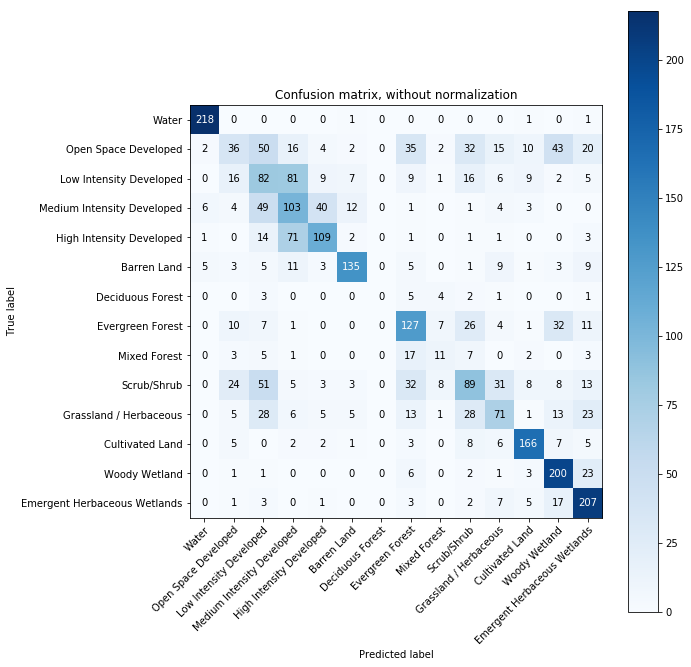

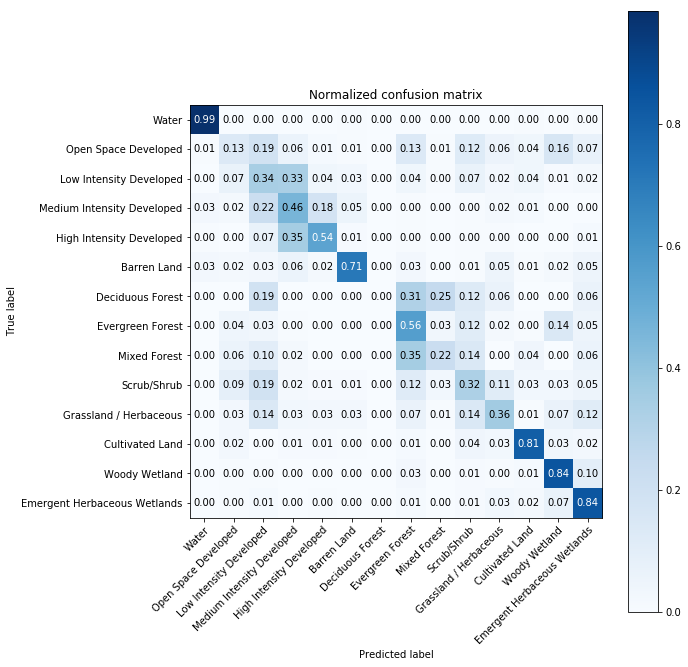

In [66]:
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
cu.plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
cu.plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [67]:
count = 0
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        count+=1
print("ACCURACY")
print(count/len(label_index))

ACCURACY
0.555


In [68]:
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

In [69]:
def merge_classes(y):
    # medium intensity and high intensity
    y[y == 2] = 4
    y[y == 3] = 4
    y[y == 5] = 4
    y[y == 7] = 8
    y[y == 9] = 8
    #y[y == 14] = 8
    #y[y==10] = 8
    return(y)

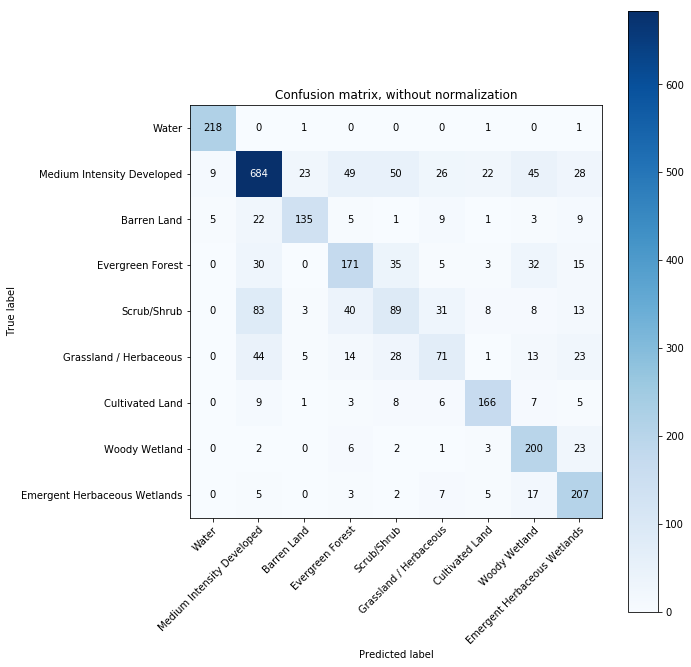

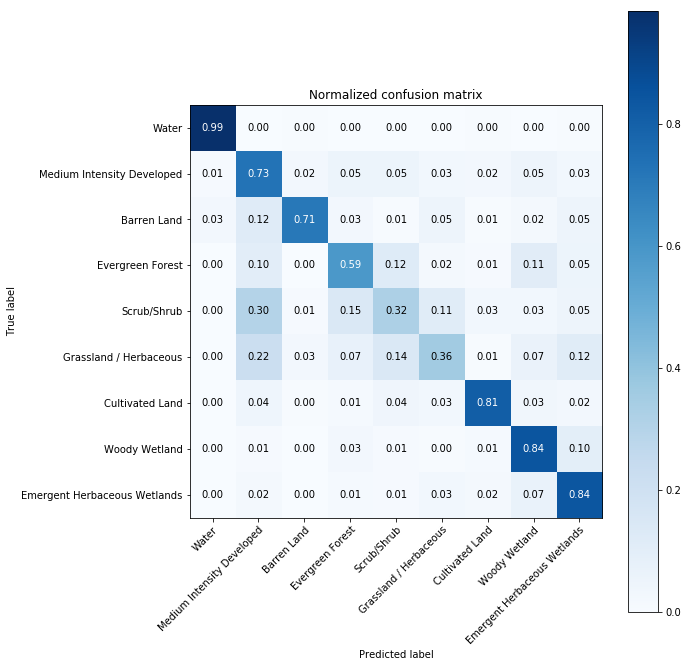

In [70]:
label_index = merge_classes(label_index)
pred_index = merge_classes(pred_index)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
cu.plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
cu.plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [71]:
count = 0
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        count+=1
print("ACCURACY")
print(count/len(label_index))

ACCURACY
0.6932142857142857
